<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/OriPytorch_17010_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Mount Google Drive to save and load the model
from google.colab import drive
drive.mount('/content/drive')

# Set seed for reproducibility
torch.manual_seed(42)

# Define the folder to save model checkpoints
checkpoint_folder = '/content/drive/My Drive/FYP/ModelCheckpoints/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Improved Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to 300x300
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for more data variety
    transforms.RandomRotation(15),  # Random rotation by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter for variation
    transforms.ToTensor(),  # Convert to tensor
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Data preparation: Training, Validation, and Test sets
data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/test'

# Load datasets
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 8  # Increased batch size for better training stability
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a more robust CNN model
class ImprovedCNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedCNN, self).__init__()
        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc1 = None
        self._initialize_fc(input_size)

    def _initialize_fc(self, input_size):
        """ Dynamically calculate FC layer size """
        with torch.no_grad():
            dummy_input = torch.randn(1, *input_size)
            dummy_output = self.pool(self.bn1(torch.relu(self.conv1(dummy_input))))
            flattened_size = dummy_output.view(1, -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 2)  # Assuming binary classification

    def forward(self, x):
        # Forward pass with convolution, batch norm, pooling, and dropout
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.dropout(x)  # Apply dropout before the final FC layer
        x = self.fc1(x)
        return x

# Initialize the improved model
input_size = (3, 300, 300)  # 3 channels, 300x300 images
model = ImprovedCNN(input_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Use Adam with an initial learning rate and a scheduler for decay
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 10% every 5 epochs

# Function to save the best model
def save_best_model(model, folder_path, best_val_acc):
    model_save_path = os.path.join(folder_path, "best_model.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Best model saved with accuracy: {best_val_acc:.4f}% at {model_save_path}")

# Training loop with best model saving
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    model.train()
    best_val_acc = 0.0  # Initialize the best validation accuracy
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        # Print the loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

        # Validate the model and check accuracy
        val_acc = validate(model, val_loader, criterion)

        # Save the model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_best_model(model, checkpoint_folder, best_val_acc)

# Validation loop returning accuracy
def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(loader)}, Accuracy: {accuracy}%')
    return accuracy  # Return accuracy to track the best model

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader)}, Test Accuracy: {accuracy}%')


# Train and validate the improved model
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Run the model on the test set
test(model, test_loader, criterion)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1/20], Loss: 63.04700061321259
Validation Loss: 17.834278958184377, Accuracy: 62.745098039215684%
Best model saved with accuracy: 62.7451% at /content/drive/My Drive/FYP/ModelCheckpoints/best_model.pth
Epoch [2/20], Loss: 12.80675023588352
Validation Loss: 13.918910571507045, Accuracy: 58.8235294117647%
Epoch [3/20], Loss: 8.831869990974665
Validation Loss: 8.290153094700404, Accuracy: 60.78431372549019%
Epoch [4/20], Loss: 5.915653438400182
Validation Loss: 2.413027532731316, Accuracy: 68.62745098039215%
Best model saved with accuracy: 68.6275% at /content/drive/My Drive/FYP/ModelCheckpoints/best_model.pth
Epoch [5/20], Loss: 3.9278940629959105
Validation Loss: 4.0254563348633905, Accuracy: 68.62745098039215%
Epoch [6/20], Loss: 2.536029438132059
Validation Loss: 1.9143593348562717, Accuracy: 76.47058823529412%
Best model saved with accuracy: 76.4706%

In [19]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

# Load and preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((300, 300)),  # Resize to the size used during training
        transforms.ToTensor(),  # Convert the image to a tensor
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Load the saved model
def load_model(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {checkpoint_path}")
    return model

# Predict the class of the specific image
def predict_image(model, image_tensor, class_names):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)  # Get the predicted class index

    predicted_class_name = class_names[predicted.item()]  # Get the class name based on the index
    return predicted_class_name

# Path to the specific image
image_path = '/content/480 (41).jpeg'
# Path to the best saved model
best_model_path = '/content/drive/My Drive/FYP/ModelCheckpoints/best_model.pth'

# Initialize the model
input_size = (3, 300, 300)  # 3 channels, 300x300 images
loaded_model = ImprovedCNN(input_size)

# Load the best saved model
loaded_model = load_model(loaded_model, best_model_path)

# Preprocess the specific image
image_tensor = preprocess_image(image_path)

# Load the dataset to get the class names
data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/train'
train_dataset = datasets.ImageFolder(data_path, transform=transform_val_test)

# The list of class names
class_names = train_dataset.classes  # This will give you a list of class labels

# Predict the class
predicted_class_name = predict_image(loaded_model, image_tensor, class_names)
print(f"Predicted class: {predicted_class_name}")


Model loaded from /content/drive/My Drive/FYP/ModelCheckpoints/best_model.pth
Predicted class: Slaty_Backed_Gull


<ipython-input-19-8f4916d36bd6>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/test/specific_image.jpg'

In [16]:
pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39589 sha256=1a4a2f68178d7b60d18476a3dbd449b83c3bbb343d5ed0bf61dcc7fa2214aeeb
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


<ipython-input-22-f5696927648d>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Model loaded from /content/drive/My Drive/FYP/ModelCheckpoints/best_model.pth


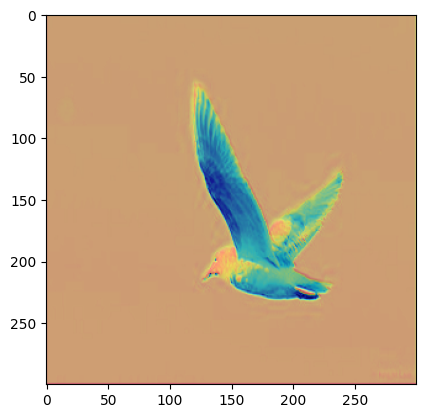

In [24]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Preprocess the image to be used with the model
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((300, 300)),  # Resize to match your training size
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to apply Grad-CAM
def apply_grad_cam(model, target_layer, image_tensor, use_cuda=False):
    cam = GradCAM(model=model, target_layers=[target_layer])  # CUDA is handled by default
    grayscale_cam = cam(input_tensor=image_tensor)[0]  # [0] to get the first image in the batch

    return grayscale_cam

# Function to visualize Grad-CAM
def visualize_cam_on_image(image_path, cam_heatmap):
    img = cv2.imread(image_path)  # Read image with OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    img = cv2.resize(img, (300, 300))  # Resize to match model input size
    img = np.float32(img) / 255.0  # Normalize to 0-1 range

    cam_image = show_cam_on_image(img, cam_heatmap, use_rgb=True)  # Overlay heatmap on image
    plt.imshow(cam_image)
    plt.show()

# Path to your test image
image_path = '/content/320 (87).jpeg'

# Preprocess the image
image_tensor = preprocess_image(image_path)

# Load the saved model
input_size = (3, 300, 300)
loaded_model = ImprovedCNN(input_size)
best_model_path = '/content/drive/My Drive/FYP/ModelCheckpoints/best_model.pth'
loaded_model = load_model(loaded_model, best_model_path)

# Set the model to evaluation mode
loaded_model.eval()

# Define the target convolutional layer (usually the last convolutional layer)
target_layer = loaded_model.conv1  # Adjust this depending on your model architecture

# Apply Grad-CAM to get the heatmap
cam_heatmap = apply_grad_cam(loaded_model, target_layer, image_tensor)

# Visualize the Grad-CAM heatmap on the original image
visualize_cam_on_image(image_path, cam_heatmap)
